In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob
import re

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")
sys.path.append("../src/tests")

In [3]:
import clustering as clstr
import bout.assembly as bt
import plot as bt_plt
import test_activity_metric_functions as test_actvt
import activity.subsampling as ss
import activity.activity_assembly as actvt
import pipeline
from core import SITE_NAMES, FREQUENCY_COLOR_MAPPINGS

from cli import get_file_paths
import pipeline

In [4]:
def plot_raw_metrics_over_audio_seg(audio_features, spec_features, plot_dets, plot_bouts, bout_params, data_params):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(f"BatDetect2 detections on {audio_features['file_path'].name}", fontsize=22)
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label='Detections')

    legend_patches = [yellow_patch]
    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
        
        ax.add_patch(rect)

    for group in bout_params.keys():
        if group != 'site_key':
            group_tag = group.split('_')[0]
            group_patch = patches.Patch(facecolor=FREQUENCY_COLOR_MAPPINGS[group_tag], edgecolor='k', label=f'BCI = {round(bout_params[group], 2)}ms')
            legend_patches += [group_patch]

    dc_tag = data_params['cur_dc_tag']
    cycle_length_in_mins = int(dc_tag.split('of')[1])
    data_params['index_time_block_in_secs'] = 5
    file_dt = dt.datetime.strptime(audio_features['file_path'].name, '%Y%m%d_%H%M%S.WAV')
    windows = pd.date_range(file_dt, file_dt+pd.Timedelta(minutes=30), freq=f'{cycle_length_in_mins}T', inclusive='left')

    if not(plot_bouts.empty):
        bt_plt.plot_bout_info(ax, audio_features, plot_bouts)
        bout_duration_per_cycle = actvt.get_bout_duration_per_cycle(plot_bouts.copy(), cycle_length_in_mins)
        bout_duration_per_cycle = bout_duration_per_cycle.reindex(windows, fill_value=0)
        bt_plt.plot_recording_periods_with_bout_duration(ax, audio_features, data_params, np.round(bout_duration_per_cycle,2))

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=14, ncol=len(legend_patches), loc=1)

    plt.tight_layout()
    plt.show()

def plot_normalized_metrics_over_audio_seg(audio_features, spec_features, plot_dets, plot_bouts, bout_params, data_params):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(f"BatDetect2 detections on {audio_features['file_path'].name}", fontsize=22)
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label='Detections')

    legend_patches = [yellow_patch]
    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
        
        ax.add_patch(rect)

    for group in bout_params.keys():
        if group != 'site_key':
            group_tag = group.split('_')[0]
            group_patch = patches.Patch(facecolor=FREQUENCY_COLOR_MAPPINGS[group_tag], edgecolor='k', label=f'BCI = {round(bout_params[group], 2)}ms')
            legend_patches += [group_patch]

    dc_tag = data_params['cur_dc_tag']
    cycle_length_in_mins = int(dc_tag.split('of')[1])
    data_params['index_time_block_in_secs'] = 5
    file_dt = dt.datetime.strptime(audio_features['file_path'].name, '%Y%m%d_%H%M%S.WAV')
    windows = pd.date_range(file_dt, file_dt+pd.Timedelta(minutes=30), freq=f'{cycle_length_in_mins}T', inclusive='left')
    
    if not(plot_bouts.empty):
        bt_plt.plot_bout_info(ax, audio_features, plot_bouts)
        bout_duration_per_cycle = actvt.get_bout_duration_per_cycle(plot_bouts.copy(), cycle_length_in_mins)
        bout_duration_per_cycle = bout_duration_per_cycle.reindex(windows, fill_value=0)
        btp_per_cycle = actvt.get_btp_per_time_on(bout_duration_per_cycle, data_params['time_on_in_secs'])
        bt_plt.plot_recording_periods_with_btp(ax, audio_features, data_params, np.round(btp_per_cycle,2))

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=14, ncol=len(legend_patches), loc=1)

    plt.tight_layout()
    plt.show()

In [5]:
site_key = 'Carp'
freq_key = 'LF'

data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = freq_key
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
file_paths = get_file_paths(data_params)

location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', index_col=0)
bout_params = bt.get_bout_params_from_location(location_df, data_params)

In [6]:
files_from_loc = sorted(list(Path(f'../data/audiomoth_recordings/').glob(pattern=f'*/{site_key}/*.WAV')))
files_from_loc

[PosixPath('../data/audiomoth_recordings/recover-20220722/Carp/20220720_030000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220722/Carp/20220720_033000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220722/Carp/20220720_040000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220722/Carp/20220720_043000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220722/Carp/20220720_050000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220722/Carp/20220720_053000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220722/Carp/20220720_060000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220722/Carp/20220720_063000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220722/Carp/20220720_070000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220722/Carp/20220720_073000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220722/Carp/20220720_080000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220

In [7]:
file = files_from_loc[11]
file

PosixPath('../data/audiomoth_recordings/recover-20220722/Carp/20220720_083000.WAV')

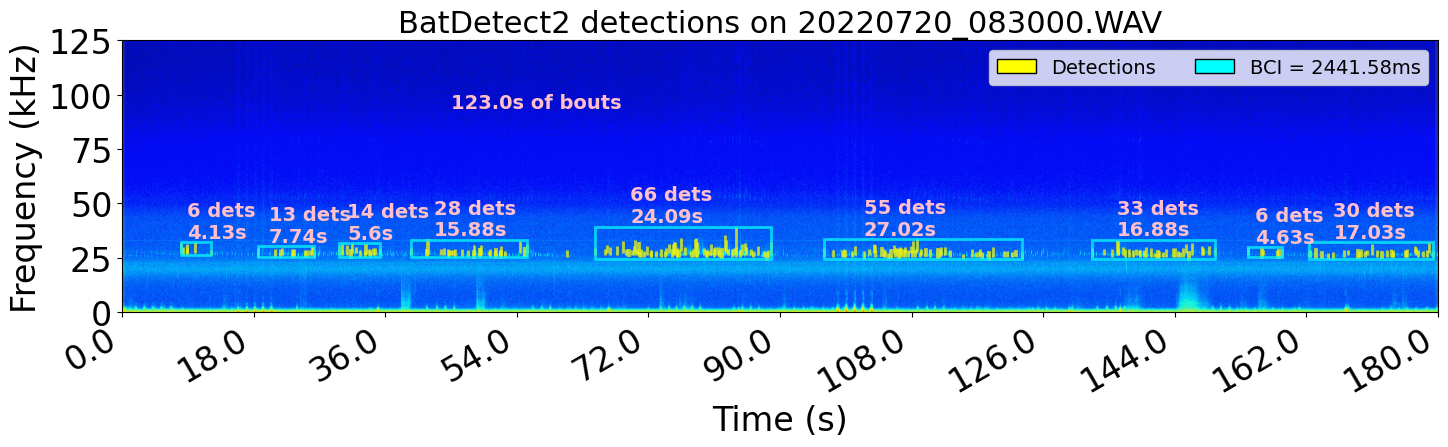

In [8]:
file_path = Path(file)
filename = file_path.name
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 0
duration = 180
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'

data_params['cur_dc_tag'] = '3of3'
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']
data_params['recording_alpha'] = 0.0

file_dt_start = dt.datetime.strptime(filename, '%Y%m%d_%H%M%S.WAV')
file_dt_end = file_dt_start + pd.Timedelta(minutes=30)

dc_applied_df = ss.simulate_dutycycle_on_detections(location_df.copy(), data_params)
plot_dets = dc_applied_df.loc[(dc_applied_df['call_start_time']>=file_dt_start)&(dc_applied_df['call_end_time']<=file_dt_end)]
plot_dets = plot_dets.loc[np.logical_and(plot_dets['start_time'] >= start, plot_dets['end_time'] <= (start+duration))]

if not(plot_dets.empty):
    bout_metrics = bt.generate_bout_metrics_for_location_and_freq(plot_dets, data_params, bout_params)
    plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] >= start, bout_metrics['end_time'] <= (start+duration))]
else:
    plot_bouts = pd.DataFrame()

plot_raw_metrics_over_audio_seg(audio_features, spec_features, plot_dets, plot_bouts, bout_params, data_params)

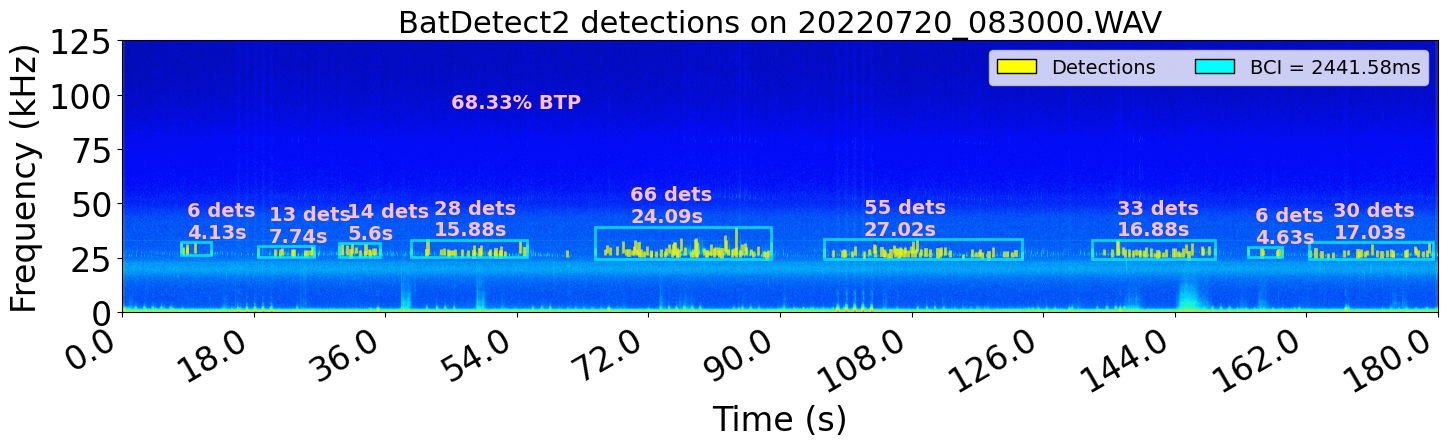

In [9]:
plot_normalized_metrics_over_audio_seg(audio_features, spec_features, plot_dets, plot_bouts, bout_params, data_params)